<a id='2'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Description </h2> </div>

The training archive contains 25,000 images of dogs and cats.

Train your algorithm on these files and predict the labels for test1.zip.
* **1 = dog**
* **0 = cat**


<a id='3'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Loading Libraries </h2> </div>

In [ ]:
# Basic
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D

<a id='4'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Extraction </h2> </div>

In [ ]:
# Giải nén data trên kaggle
train_path = "/content/dataset1/test1.zip"
test_path = "/content/dataset1/train.zip"

files = "/kaggle/working/"

import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)

with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

### Loading Images in a Dataframe

In [ ]:
# Xem thử data đang ở dạng nào để chuẩn bị chỉnh về format phù hợp với đầu vào của tensorflow
# Hiện tại 1 folder train đang chứa tất cả ảnh chó lẫn mèo
# data có 25000 ảnh có số lượng ảnh chó mèo bằng nhau là 12500
image_dir = "../working/train/"

filenames = os.listdir(image_dir)
show_head = filenames[:10]
print(show_head)
print(f'Total Images: {len(filenames)}')

['cat.3480.jpg', 'dog.7962.jpg', 'cat.6952.jpg', 'cat.1707.jpg', 'cat.7252.jpg', 'dog.9702.jpg', 'cat.3339.jpg', 'cat.4016.jpg', 'cat.10833.jpg', 'dog.6428.jpg']
Total Images: 25000


In [ ]:
!unzip -q /content/dataset1/train.zip

In [ ]:
!unzip -q /content/dataset1/test1.zip

In [ ]:
# Đoạn code để xóa ngẫu nhiên 50% data chó mèo để giảm thời gian train
# Cũng như là để làm mất cân bằng data chó và mèo để cho hàm Gen Image của tensor có tác dụng
import os
import random
import shutil

folder_path = '/kaggle/working/train'
random.seed(42)

files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
num_files_to_delete = int(len(files) * 0.5)
files_to_delete = random.sample(files, num_files_to_delete)

for file in files_to_delete:
    file_path = os.path.join(folder_path, file)
    os.remove(file_path)

print(f"Đã xóa {num_files_to_delete} file ngẫu nhiên.")

Đã xóa 12500 file ngẫu nhiên.


In [ ]:
# tổng lượng ảnh còn lại sau khi xóa ngẫu nhiên 50%
len(os.listdir('/kaggle/working/train'))

12500

In [ ]:
# Move ảnh chó mèo về 2 folder Dog, Cat để đúng format của tensorflow
import os
import shutil

def move_file(folder_path):
    os.makedirs(os.path.join(folder_path, 'dog'), exist_ok=True)
    os.makedirs(os.path.join(folder_path, 'cat'), exist_ok=True)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            if 'dog' in filename:
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'dog', filename))
            elif 'cat' in filename:
                shutil.move(os.path.join(folder_path, filename), os.path.join(folder_path, 'cat', filename))

# move_file('/kaggle/working/test1')
move_file('/kaggle/working/train')

<a id='5'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Exploration </h2> </div>

First, we start by visualizing the variable of interest.

Let's view more images in a grid format.

<h5 style="text-align:center;color:Green">We visualize few images of Dogs. </h5>

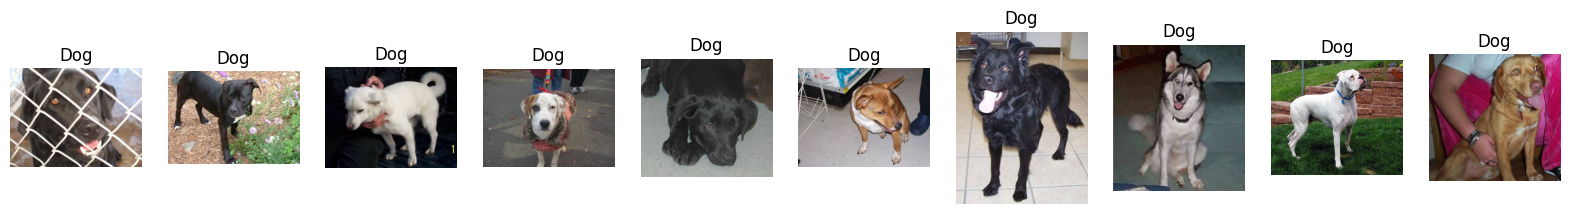

In [ ]:
# Show ảnh chó
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)
dog_dir = '/kaggle/working/train/dog'
dog_list = os.listdir(dog_dir)
for i in range(10):
    plt.subplot(1,10,i+1)
    filename = os.path.join(dog_dir, dog_list[i])
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

<h5 style="text-align:center;color:Red">We visualize few images of Cats. </h5>

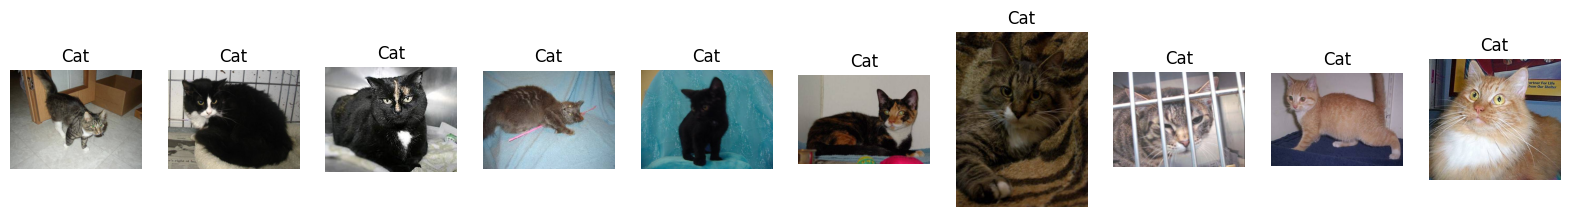

In [ ]:
# Show ảnh mèo
plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)
cat_dir = '/kaggle/working/train/cat'
cat_list = os.listdir(cat_dir)
for i in range(10):

    plt.subplot(1,10,i+1)    # the number of images in the grid is 10*10 (100)
    filename = os.path.join(cat_dir, cat_list[i])
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()

Images are of varying size.

Every time the cell is run different set of images will be displayed, one can scan the images of both categories. Presence of humans in some images could be a challenge for the model to classify.

Some images have more than one cats or dogs respectively.

Now we will Create a barplot to see the class distrubtion in trainting dataset.

<a id='9'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Preparation </h2> </div>

firstly, we will list out all the important parameters and respective values.

In [ ]:
# Tổng số lượng ảnh chó và mèo trong mỗi folder
dog_path = '/kaggle/working/train/dog'
cat_path = '/kaggle/working/train/cat'
print(f'Total Dog Images: {len(os.listdir(dog_path))}')
print(f'Total Cat Images: {len(os.listdir(cat_path))}')

Total Dog Images: 6280
Total Cat Images: 6220


<a id='10'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black">Image Data Generator </h3> </div>

* The data for will used by flow_from_dataframe and flow_from_directory.
* The batch size is 32 and the image size is (128,128).


In [ ]:
# Tạo hàm Gen Ảnh trong tensor, nó sẽ augment ảnh để đủ số lượng ảnh chó mèo bằng nhau
# validation_split=0.2 sẽ chia tập test 20%, train 80%,
# còn lại là các chỉ số để augment ảnh như xoay, lật, dịch chuyển ảnh, zoom
datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

train_generator = datagen.flow_from_directory( '/kaggle/working/train',
                                                    subset='training',
                                                    target_size=(128, 128),
                                                    batch_size=64,
                                                    class_mode='binary')

val_generator = datagen.flow_from_directory( '/kaggle/working/train',
                                                    subset='validation',
                                                    target_size=(128, 128),
                                                    batch_size=64,
                                                    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


<a id='13'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Deep Learning Model </h2> </div>

<a id='14'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black">Model Layers </h3> </div>


### Architecture

The architecture of the Cat vs Dog Image Classification model consists of the following Layers and components:

#### Layers :
* The input layer consist of a Conv2D with 32 filters and activation relu.
* The model contain the 3 blocks of convolution with increasing filters and activation relu.
* Each convolution block contains Batch Noramlization, Max pooling (pool_size = 2) and Dropout (0.2).
* The fully connected layers contain Flatten layer, Dense layer with 512 units and a Dropout layer.
* The output layer is a Dense layer with 2 units and softmax activation.

#### Components:

* **Input Layer:** Receives input images for classification.
* **Convolutional Layers:** Extract features from the images through convolutional operations.
* **Pooling Layers:** Reduce the spatial dimensions of the feature maps.
* **Flatten Layer:** Convert the 2D feature maps into a 1D vector.
* **Fully Connected Layers:** Perform classification using densely connected layers.
* **Output Layer:** Provides the final prediction probabilities for cat and dog classes.

In [ ]:
# Tạo model để train
# các lớp Conv2d tốt cho việc học đặc trưng của ảnh
# Maxpool2D giảm chiều dữ liệu bằng cách lấy giá trị lớn nhất trong kernal khi trượt trên ảnh
# BatchNorm để chuẩn hóa dữ liệu khi train, khiến cho việc dịch chuyển gradient dễ dàng hơn
# DropOut để xóa ngẫu nhiên 20% parameter trong layer khi train giúp cho model ko bị overfit
# Flatten để đưa ảnh về dạng 1d , làm mượt ảnh để chuẩn bị cho lớp dense
# Các lơp dense để train ảnh, lớp cuối là 1 để đồng dạng với ouput của bài toán
model = tf.keras.models. Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers. MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers. Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers. MaxPooling2D (2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers. MaxPooling2D (2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers. MaxPooling2D (2,2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers. Flatten(),
    tf.keras.layers. Dense (512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers. Dense (1, activation='sigmoid') ])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,001 (19.50 MB)

 Trainable params: 5,110,017 (19.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

<a id='15'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Callbacks </h3> </div>
we will be using two callbacks -

* **ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.
* **EarlyStopping :** Stop training when a monitored metric has stopped improving.

In [ ]:
# Tạo hàm call back dừng model khi accuracy đạt trên 92%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') and logs.get('accuracy')>=0.92) :
            print('\n reached 92 % accuracy so counceling training')
            self.model.stop_training = True

callback = MyCallback()

<a id='23'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Compile the model </h3> </div>
Finally we will compile the model .There are 3 things to mention here : Optimizer,Loss, Metrics

* **Optimizer** :- To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.
​
* **Loss** :- To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy.
​
* **Metrics** :- This is to denote the measure of your model. Can be accuracy or some other metric.

In [ ]:
# Complie cho model , dùng optimizer adam
# Loss BCE cho bài toán phân loại 2 class
# Metric để đánh giá model theo accucary
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

<a id='16'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Fit the model </h3> </div>

We are now going to train our compiled model using the train iterator (train_generator) and use the val iterator (val_generator) as a validation dataset during training.

The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and validation directories divided by the batch size (32).

The model will be fit for 30 epochs.

In [ ]:
# Train model
cat_dog = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[callback],
                    epochs = 30,
                   )

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726715666.370589      82 service.cc:145] XLA service 0x7e8dd0007130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726715666.370647      82 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/157 ━━━━━━━━━━━━━━━━━━━━ 44:52 17s/step - accuracy: 0.5625 - loss: 0.9400

I0000 00:00:1726715677.514811      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 440ms/step - accuracy: 0.5958 - loss: 0.9072 - val_accuracy: 0.4976 - val_loss: 2.4767
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 363ms/step - accuracy: 0.6932 - loss: 0.5966 - val_accuracy: 0.4976 - val_loss: 1.5462
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 358ms/step - accuracy: 0.7194 - loss: 0.5489 - val_accuracy: 0.5740 - val_loss: 0.7646
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 57s 351ms/step - accuracy: 0.7536 - loss: 0.4941 - val_accuracy: 0.6868 - val_loss: 0.5919
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 354ms/step - accuracy: 0.7794 - loss: 0.4593 - val_accuracy: 0.6528 - val_loss: 0.7471
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 373ms/step - accuracy: 0.8056 - loss: 0.4240 - val_accuracy: 0.7364 - val_loss: 0.8727
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 387ms/step - accuracy: 0.8190 - loss: 0.4021 - val_accuracy: 0.6888 - val_loss: 0.7851
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 378ms/step - accuracy: 0.8304 - loss: 0.3837 - val

<a id='17'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Plot the results </h3> </div>

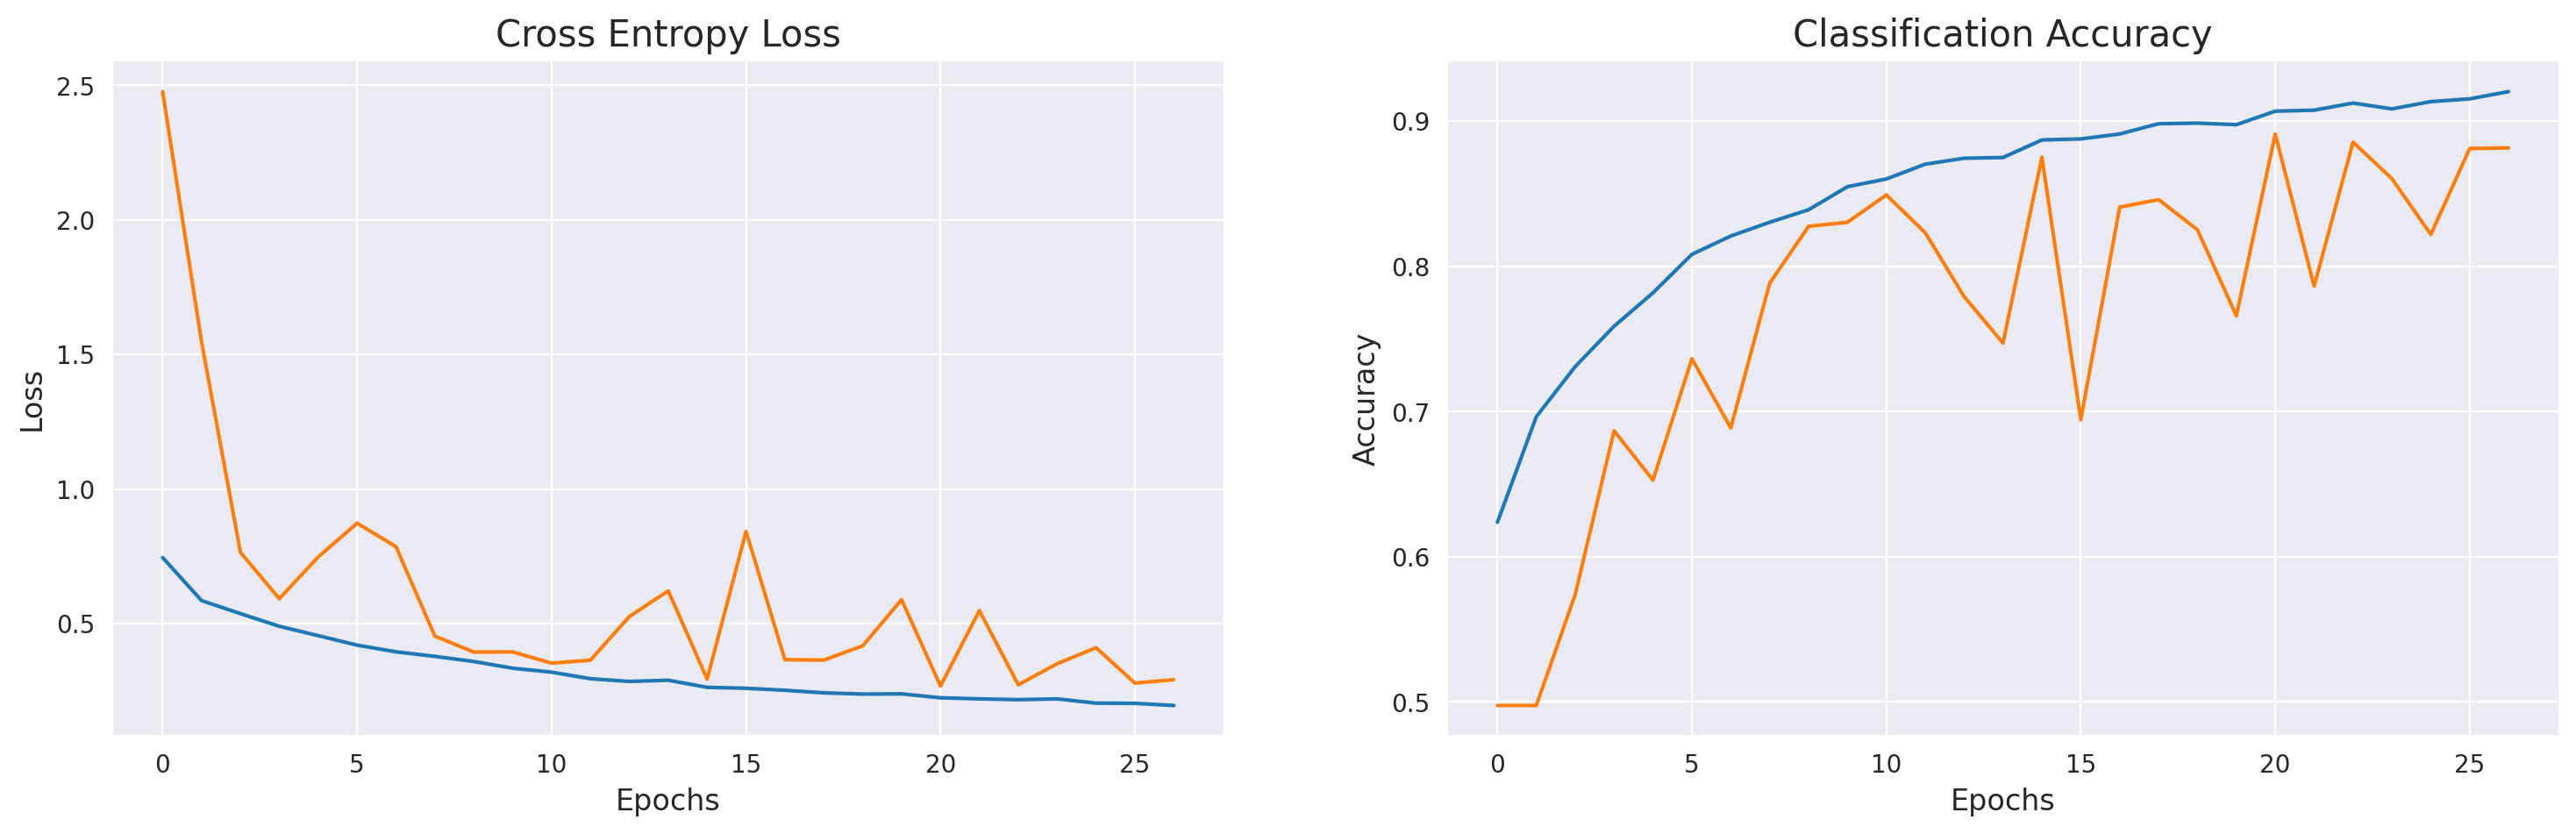

In [ ]:
# plots for accuracy and Loss with epochs

# Show biểu đồ Loss và Accuracy khi vừa train model xong
error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

<a id='18'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Evaluvation </h3> </div>

we will evaluvate the Training and validation data accuracy and loss.

In [ ]:

loss,acc = model.evaluate(train_generator,batch_size = 64, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(val_generator,batch_size = 64, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 89.46999907493591
The Loss of the model for training data is: 0.23812861740589142
The accuracy of the model for validation data is: 86.8399977684021
The Loss of the model for validation data is: 0.3142087161540985


Finally, we will save the model for future use.

In [ ]:

model.save("model.h5")

<a id='19'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Prediction </h2> </div>

Now, we will predict the model on test dataset.

Classification report

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


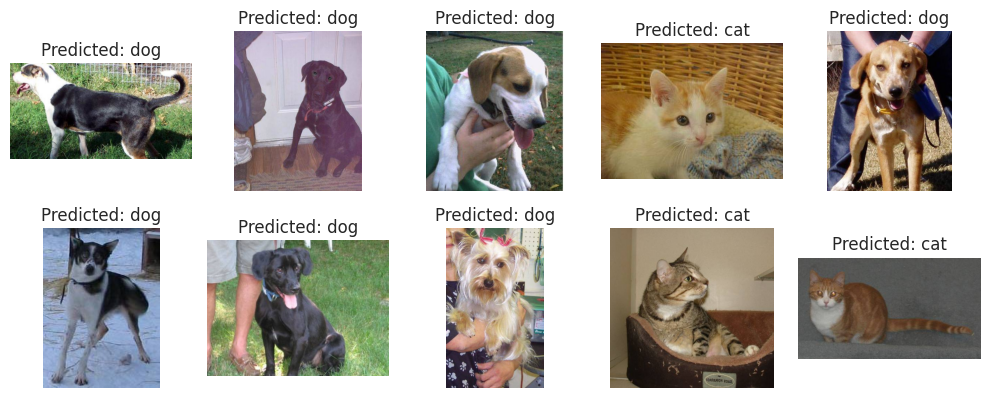

In [ ]:

import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np


# Show ảnh predict, để threashold là 0.5

test_folder_path = '/kaggle/working/test1'
model_path = '/kaggle/working/model.h5'

model = tf.keras.models.load_model(model_path)

test_images = [f for f in os.listdir(test_folder_path) if f.endswith('.jpg')]

random.seed(42)
sample_images = random.sample(test_images, 10)

def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension
    img_array = img_array / 255.0  # Chuẩn hóa giá trị ảnh
    return img_array

plt.figure(figsize=(10, 10))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(test_folder_path, img_name)
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_prob = prediction[0][0]

    if predicted_prob >= 0.5:
        predicted_label = 'dog'
    else:
        predicted_label = 'cat'
    img = image.load_img(img_path)
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir dataset1

In [ ]:
!unzip -q /content/drive/MyDrive/dogs-vs-cats.zip -d /content/dataset1